# MultiObjective GFlowNet Results
In this notebook, we present the MultiObjective GFlowNet results on the gridworlds. We present the following results:
1. Qualitative results of 3D objective function
2. Quantitative results on 3D objective function
3. Annealing  
4. Scaling results

### Import relevant packages  

In [1]:
import grid_cond_gfn as gfn
import itertools
import torch
import matplotlib.pyplot as pp
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import pickle
import gzip
import numpy as np
import os
import scipy.stats as stats
from itertools import product
from collections import defaultdict 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import figure

top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

mpl.rc('image', cmap=newcmp)

def binavg(x, n=100, var=False, 
            bounds=False, logx=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x, 0*x+1, 0 * x, np.stack([x, x]).T
    if logx:
        bins = np.logspace(0, np.log(len(x))/np.log(10), n)
        idx = np.digitize(np.arange(len(x)), bins)
    else:
        bins = np.linspace(0, len(x), n)
        idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    counts = np.bincount(idx, minlength=n)
    _y = y = np.bincount(idx, x, minlength=n) / counts
    bins = bins[counts>0]
    y = y[counts>0]
    r = (bins, y, counts)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - _y**2)
        r += (var[counts>0], )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n) if counts[i] > 0]), ) 
    return r
 
def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, logx=False, **kw):
    bins, y, counts, var, bounds = binavg(x, n, var=True, bounds=True, logx=logx)
    if 'bins' in kw:
        bins = kw.pop('bins')[counts>0]
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualize the reward functions

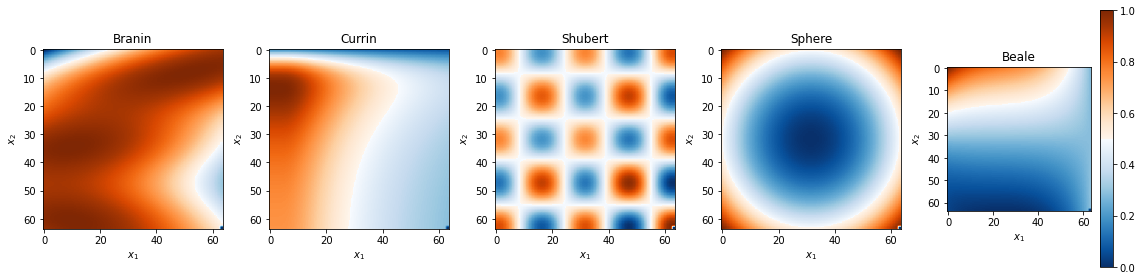

In [3]:
def get_functions(dims):
    functions = [gfn.branin, gfn.currin, gfn.shubert, gfn.sphere, gfn.beale]
    function_labels = ["Branin", "Currin", "Shubert", "Sphere", "Beale"]
    if dims == 3:
        return functions[:3], function_labels[:3]
    elif dims == 4:
        return functions[:4], function_labels[:4]
    else:
        return functions, function_labels

def visualize_reward():
    H = 64
    functions, function_labels = get_functions(dims=5)
    env = gfn.GridEnv(H, funcs=functions)
    s, r, pos = env.state_info()
    f, ax = pp.subplots(1,len(functions), figsize=(16,4))
    for i in range(len(functions)):
        pp.sca(ax[i])
        reward = r[:, i]
        pp.imshow(np.concatenate([reward, [0]]).reshape((H,H)))
        pp.xlabel('$x_1$')
        pp.ylabel('$x_2$')
        pp.title(function_labels[i])
    pp.colorbar()
    pp.tight_layout()
    pp.savefig("all_plots/rewards.png")
visualize_reward()

### Qualitative analysis of MO-GFN where we use a 3D objective function 

In this experiment, we use a three dimensional objective function so the reward vector for a given state $s \in \mathcal{S}$ looks like this: `R(s) = [Branin(s), Currin(s), Shubert(s)]`. We train a GFN where we condition the network on 1) Preference vectors $\omega = [\omega_1, \omega_2, \dots \omega_n]$ (where $n = 3$ in this specific case) and 2) Inverse temperature parameter $\beta$. 

**Aim:** The aim is to train the conditional GFN in such a way that we learn a density model proportional to the reward: $p(x|\omega, \beta) \propto R(x|\omega, \beta)$

#### Visualization of the true reward conditioned on temperature and preferences
As a first step, let's try to visualize how our reward function looks like conditioned on some preferences. Here, for visualization purposes, we randomly sample 10 preference vectors from dirichlet distribution. 

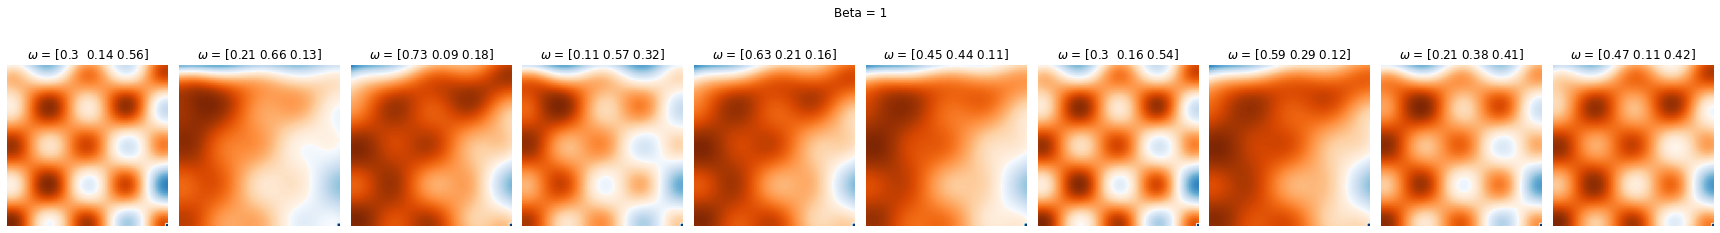

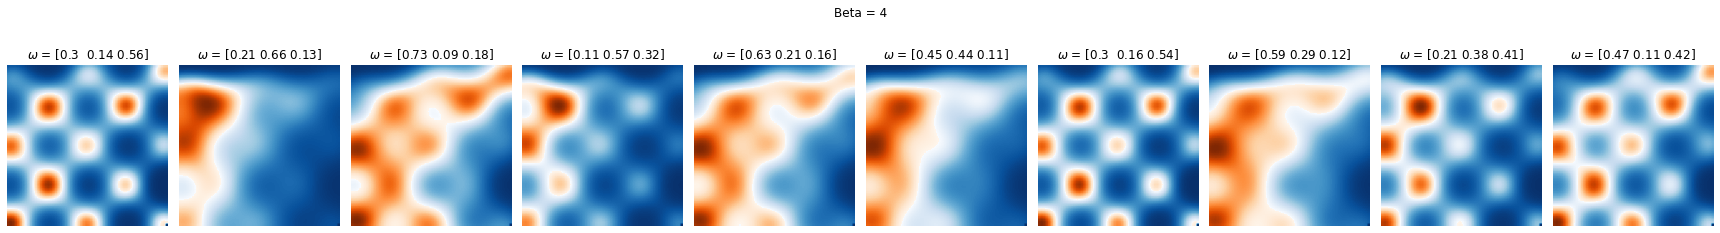

In [5]:
functions, _ = get_functions(dims=3)
preferences = np.random.dirichlet([1.5]*len(functions), size=10)
def reward_dist_with_preferences(preferences, beta, dims=3):
    H = 64
    env = gfn.GridEnv(64, funcs=functions)
    s, r, pos = env.state_info()
    f, ax = pp.subplots(1,preferences.shape[0], figsize=(24,4))
    for i in range(preferences.shape[0]):
        pp.sca(ax[i])
        y = 0
        for j in range(r.shape[-1]):
            y += r[:, j] * preferences[i, j]
        y = y ** beta
        pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
        pp.axis('off')
        pp.title(f'$\omega$ = {np.around(preferences[i], 2)}')
    pp.tight_layout()
    pp.suptitle("Beta = {}".format(beta))
    pp.savefig("conditional_rewards.png")
reward_dist_with_preferences(preferences, beta=1)
reward_dist_with_preferences(preferences, beta=4)

#### Results
Now lets visualize some of the qualitative results of MO-GFN. 



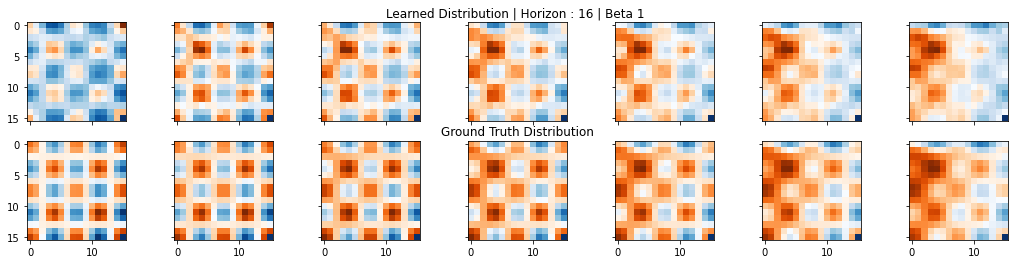

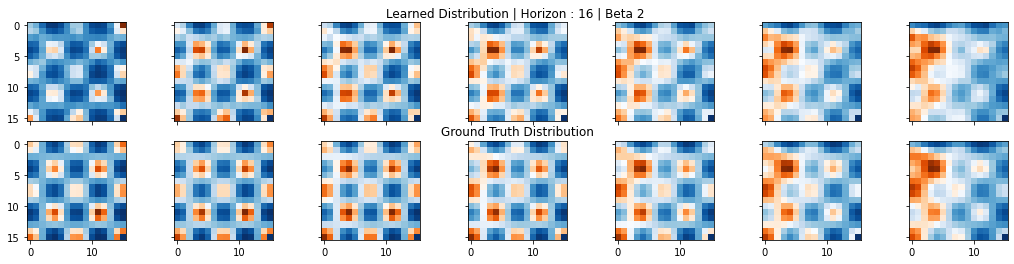

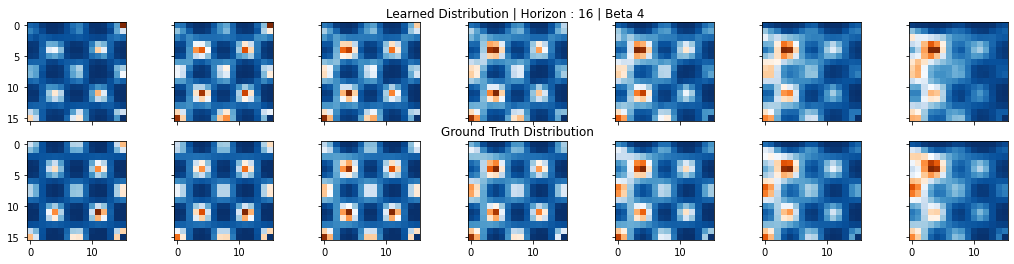

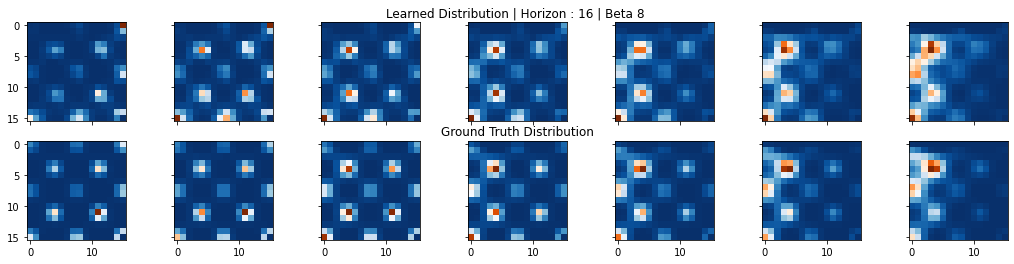

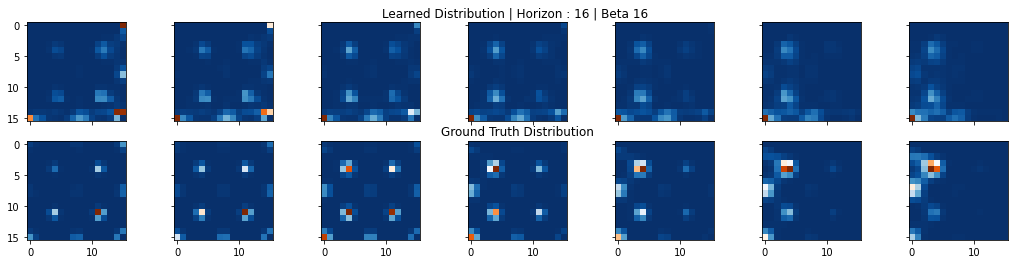

In [6]:
def plot_beta_evolution(horizon, dims, method):
    results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/{}_{}d_horizon_{}.pkl.gz'.format(method, dims, horizon), 'rb'))
    H = results['args'].horizon
    functions, _ = get_functions(dims)
    env = gfn.GridEnv(H, funcs=functions)
    s, r, pos = env.state_info()
    row = 0
    betas_idxs = range(5)
    betas = [1, 2, 4, 8, 16]
    for beta in betas_idxs:
        f, ax = pp.subplots(2,7,figsize=(18,4), sharex=True, sharey=True)
        coefs = [] # This is a bad bad bad way of coding
        for col in range(7):
            coef, temp = results['cond_confs'][col * 5 + beta]
            coefs.append(coef)
            pp.sca(ax[0, col])
            if col == 3:
                pp.title("Learned Distribution | Horizon : {} | Beta {} ".format(H, betas[beta]))
            pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + beta], [0]]).reshape((H,H)))
            pp.sca(ax[1, col])
            if col == 3:
                pp.title("Ground Truth Distribution")
            pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((H,H)))
        pp.savefig(os.getcwd() + '/plots/method_evol_horizon_{}_beta_{}_coefs_{}_v2.png'.format(horizon, betas[beta], coef))
    return coefs
_ = plot_beta_evolution(horizon=16, dims=3, method="const")

**Observations:** We can see that the model is able to detect the modes decently but not that perfect. Especially foe higher beta, the model is not even able to detect the modes. But lets also look at the loss curve to get some quantitative results. Here we plot the loss curve where the loss is measured w.r.t to the true distribution. More specifically we take the absolute difference between the predicted distribution and true distribution across all preferences and betas. 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


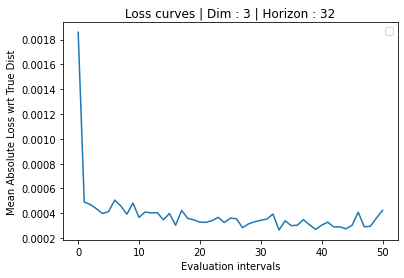

In [7]:
def plot_loss_curve(horizon, dims, method):
    results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/{}_{}d_horizon_{}.pkl.gz'.format(method, dims, horizon), 'rb'))
    functions, _ = get_functions(dims)
    env = gfn.GridEnv(horizon, funcs=functions)
    s, r, pos = env.state_info()
    data = results["true_losses"]
    pp.plot(data)
    pp.legend()
    pp.title("Loss curves | Dim : {} | Horizon : {}".format(dims, horizon))
    pp.xlabel("Evaluation intervals")
    pp.ylabel("Mean Absolute Loss wrt True Dist")
    pp.savefig("loss_curves_{}_{}_{}.png".format(method, dims, horizon))
plot_loss_curve(horizon=32, dims=3, method="const")

This loss curve looks decent but it is not conveying information about the models ability to capture the peaks. 
But atleast from the qualitative results we can see that our model is struggling. So the question now is can we do better?

To answer this question, let's look at how we are training the MO-GFN and more specifically how we are sampling the betas. For all of the above results we are sampling the beta value from a gamma distribution `Gamma(a, b)` with parameters `a = 2` and `b = 1`. One hypothesis could be that by using this sampling strategy for beta, it is diffcult for the model to see high beta values and hence the generalization is not so great! To verify this hypothesis, we can perform two useful experiments:

1. Fix the beta parameter throughout the traning. We are performing this experiment to test the models ability to capture peaks. Altough the model will likely fail to generalize to other beta's we are more interested to see if the model is capturing the peaks. We plot the qulitative visualization and also quantitative learning curve for MO-GFN trained only with beta=8
2. We can perform "Annealing". Here the idea is to start with low beta values and slowly increase them during training. To do this, we change the shape parameter `a` in the gamma distribution while keeping `b=1`. Similar to #1, we plot the qulitative visualization and also quantitative learning curve for MO-GFN


##### Constant Beta Results

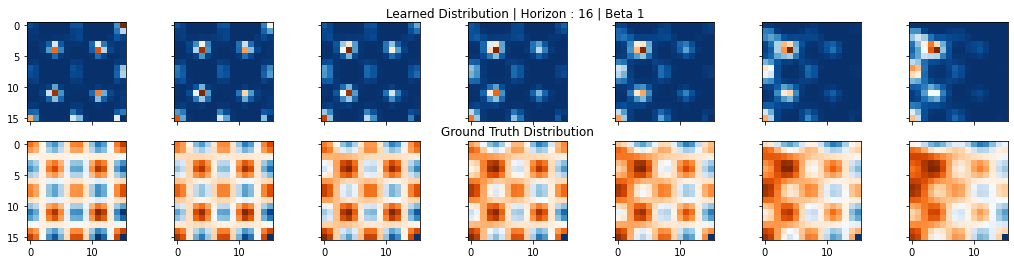

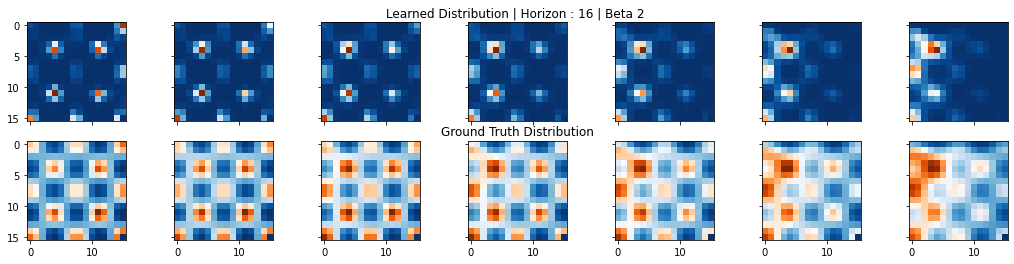

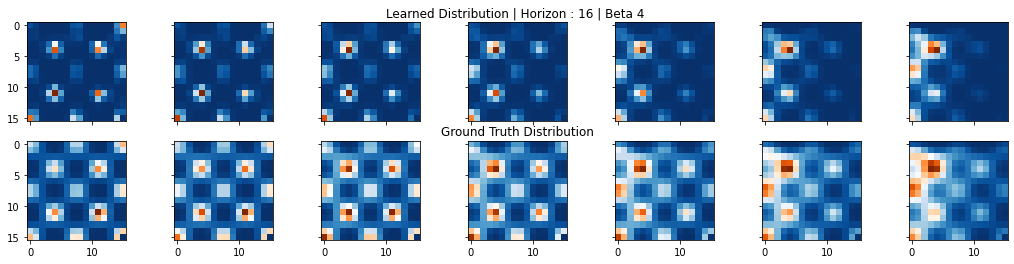

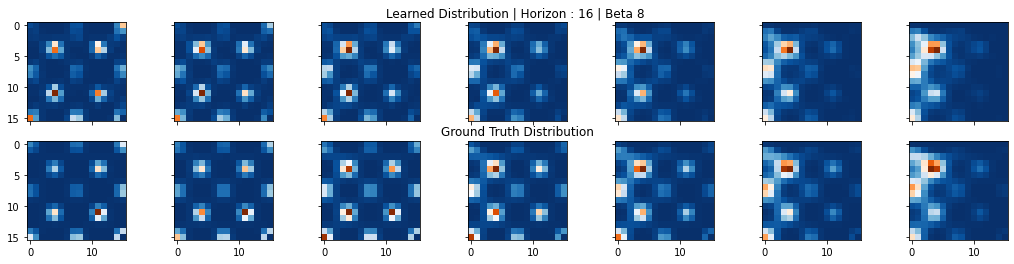

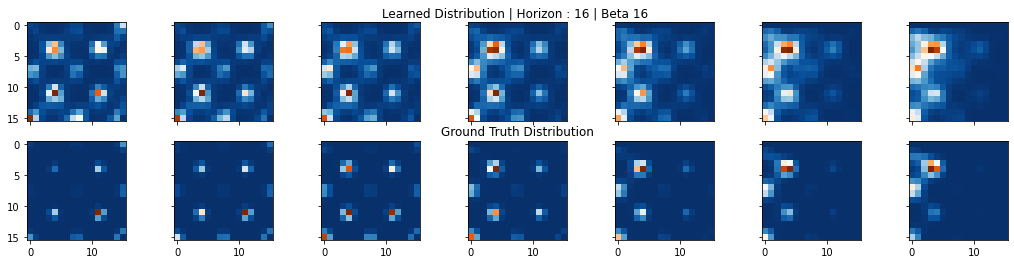

In [8]:
_ = plot_beta_evolution(horizon=16, dims=3, method="dirac")

##### Annealing Results

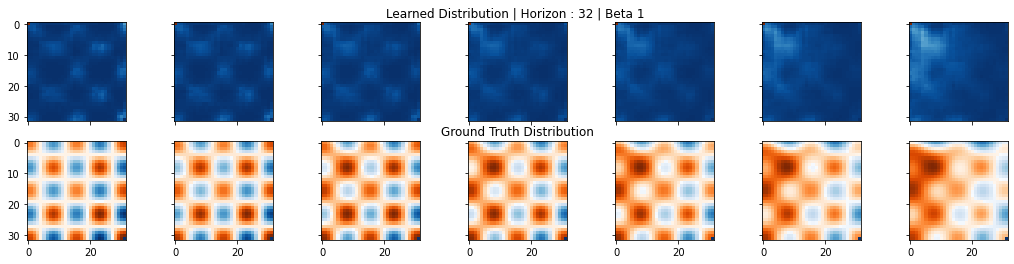

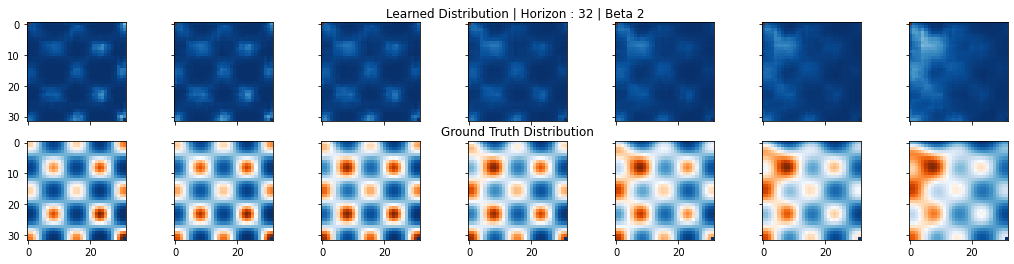

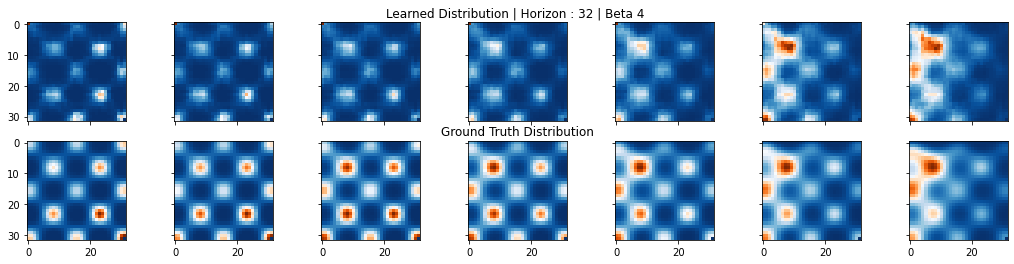

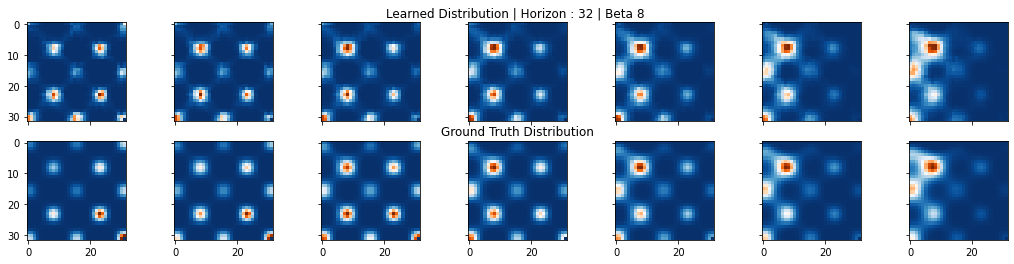

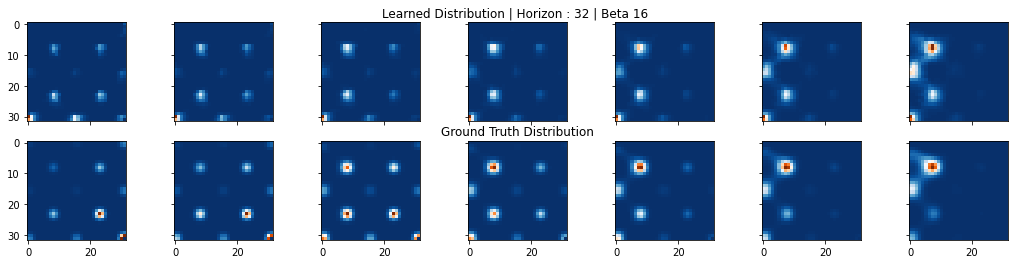

In [21]:
_ = plot_beta_evolution(horizon=32, dims=3, method="annealing")

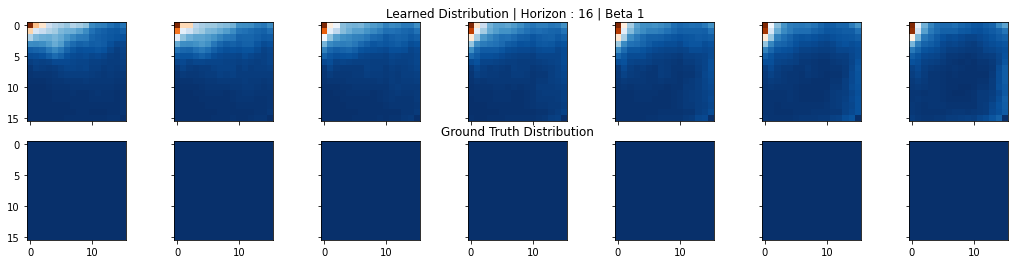

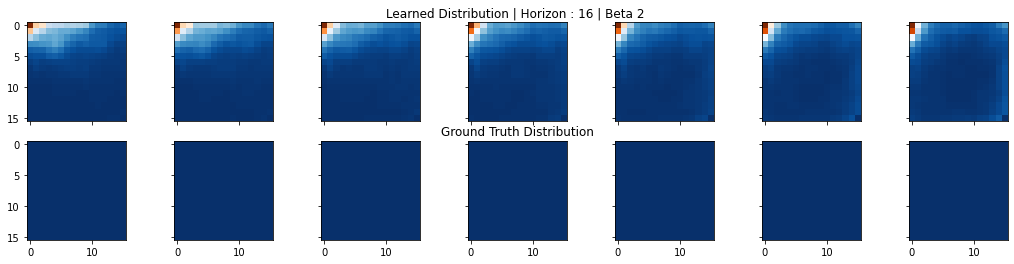

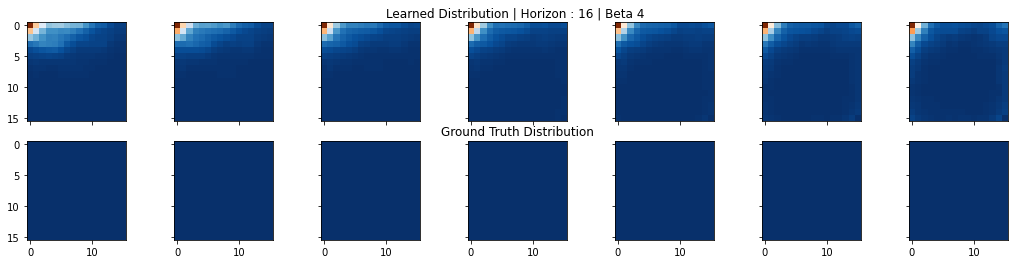

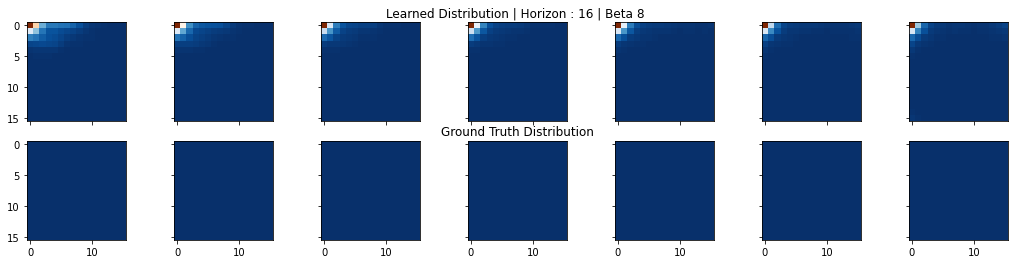

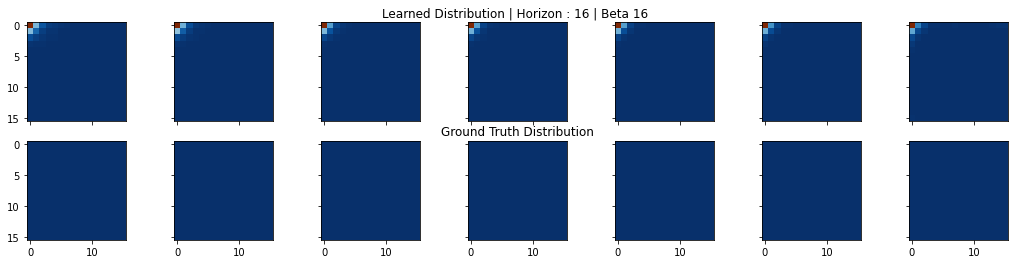

In [20]:
_ = plot_beta_evolution(horizon=16, dims=5, method="annealing")

#### Loss curves for Dirac and Annealing 

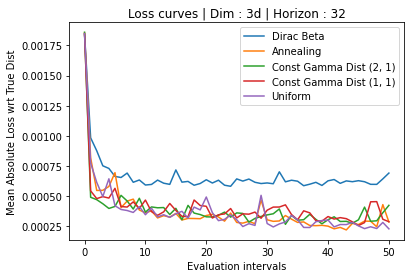

In [14]:

df = pd.DataFrame(columns=['Dimension', 'Method','Losses'])
horizon = 32
dim = "3d"
absolute = True
functions, _ = get_functions(3)
files = [f"dirac_{dim}_horizon_{horizon}.pkl.gz", f"annealing_{dim}_horizon_{horizon}.pkl.gz", f"const_{dim}_horizon_{horizon}.pkl.gz", f"const_1_1_{dim}_horizon_{horizon}.pkl.gz", f"uniform_{dim}_horizon_{horizon}.pkl.gz"]
x_labels = ["Dirac Beta", "Annealing", "Const Gamma Dist (2, 1)" , "Const Gamma Dist (1, 1)", "Uniform"]
for idx, f in enumerate(files):
    results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/' + f, 'rb'))
    env = gfn.GridEnv(horizon, funcs=functions)
    s, r, pos = env.state_info()
    data = results["true_losses"]
    pp.plot(data, label=x_labels[idx])
pp.legend()
pp.title("Loss curves | Dim : {} | Horizon : {}".format(dim, horizon))
pp.xlabel("Evaluation intervals")
pp.ylabel("Mean Absolute Loss wrt True Dist")
pp.savefig("loss_curves_{}_{}.png".format(dim, horizon))

**Observations**
1. From qualitative results, our hypothesis is verified and our model is indeed able to capture the modes with constant beta training.
2. Annealing actually seems to help. The model is consistently capturing the modes across all betas. 
3. From the loss curves, annealing seem to perform slightly better on average.  


### Scaling Results
Now, lets analyze the scaling behavior of MO-GFNs where we scale the dimensions of the reward function. Here we scale from $3D$ to $5D$

/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/dirac_3d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/annealing_3d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/const_3d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/const_1_1_3d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/uniform_3d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/dirac_4d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/annealing_4d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/const_4d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/const_1_1_4d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/examples/resultsv3/uniform_4d_horizon_16.pkl.gz
/run/determined/workdir/home/gflownet/gflownet/exa

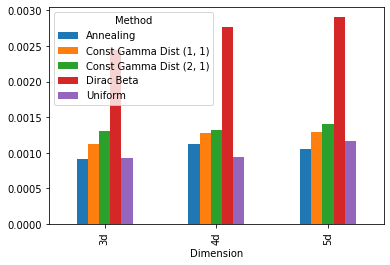

In [15]:
df = pd.DataFrame(columns=['Dimension', 'Method','Losses'])
horizon = 16
dimensions = ["3d", "4d", "5d"]
absolute = True

functions = []
for d in range(3, 6):
    funcs, _ = get_functions(d)
    functions.append(funcs)
    
for dim_idx, dim in enumerate(dimensions):
    # "Const Gamma Dist"
    files = [f"dirac_{dim}_horizon_{horizon}.pkl.gz", f"annealing_{dim}_horizon_{horizon}.pkl.gz", f"const_{dim}_horizon_{horizon}.pkl.gz", 
            f"const_1_1_{dim}_horizon_{horizon}.pkl.gz", f"uniform_{dim}_horizon_{horizon}.pkl.gz"]

    x_labels = ["Dirac Beta", "Annealing", "Const Gamma Dist (2, 1)", "Const Gamma Dist (1, 1)", "Uniform"]
    for idx, f in enumerate(files):
        results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/' + f, 'rb'))
        print(os.getcwd() + '/resultsv3/' + f)
        env = gfn.GridEnv(horizon, funcs=functions[dim_idx])
        s, r, pos = env.state_info()
        data = results
        errs = []
        logerrs = []
        for (coef, t), dist in zip(data['cond_confs'], data['final_distribution'].T):
            unnorm_p = 0
            for i in range(r.shape[-1]):
                unnorm_p += r[:, i]*coef[i]
            
            unnorm_p = unnorm_p ** t
            Z = unnorm_p.sum()
            p = unnorm_p / Z
            errs.append(abs(dist - p).mean())
        
        loss = sum(errs) / len(errs)
        if not absolute:
            if idx == 0:
                dirac_loss = sum(errs) / len(errs)
        else:
            dirac_loss = 1.0
            # logp = np.log(unnorm_p) - np.log(Z)
            # logerrs.append(abs(np.log(dist) - logp).mean())
        df = df.append({ 'Dimension' : dim, 'Method' : x_labels[idx], 'Losses' : loss / dirac_loss}, 
                ignore_index = True)
print(df)

df.pivot('Dimension', 'Method', 'Losses').plot(kind='bar')
pp.savefig("scaling_plots_dims_{}_abs.png".format(horizon))

In [112]:
# Uniform
# Gamma (1, 1)

# Exploration plots 


1.0576864076155186